In [1]:
import pandas as pd
import numpy as np

In [2]:
weather = pd.read_csv("weather_features.csv")
energy = pd.read_csv("energy_dataset.csv")

In [3]:
# Make a city-level merged dataset
df_cities = pd.merge(
    weather,
    energy,
    left_on='dt_iso',
    right_on='time',
    how='inner'
)

print("df_cities shape:", df_cities.shape)
df_cities.head()


df_cities shape: (178396, 46)


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [4]:
df_cities.info()
df_cities['city_name'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 46 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   dt_iso                                       178396 non-null  object 
 1   city_name                                    178396 non-null  object 
 2   temp                                         178396 non-null  float64
 3   temp_min                                     178396 non-null  float64
 4   temp_max                                     178396 non-null  float64
 5   pressure                                     178396 non-null  int64  
 6   humidity                                     178396 non-null  int64  
 7   wind_speed                                   178396 non-null  int64  
 8   wind_deg                                     178396 non-null  int64  
 9   rain_1h                                      178396 non-nul

,count
city_name,
Madrid,36267
Bilbao,35951
Seville,35557
Barcelona,35476
Valencia,35145


# 1. Average temperature by city

/tmp/ipython-input-1391189549.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city_name', y='temp_c', data=df_cities, palette='coolwarm')


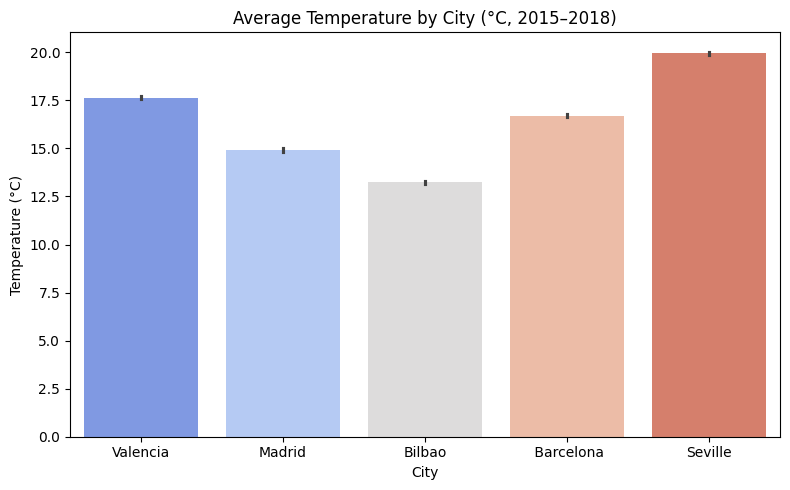

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df_cities['temp_c'] = df_cities['temp'] - 273.15  # convert K → °C

plt.figure(figsize=(8,5))
sns.barplot(x='city_name', y='temp_c', data=df_cities, palette='coolwarm')
plt.title('Average Temperature by City (°C, 2015–2018)')
plt.xlabel('City')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()



#2. Temperature trend comparison (sample 1 year to reduce clutter)

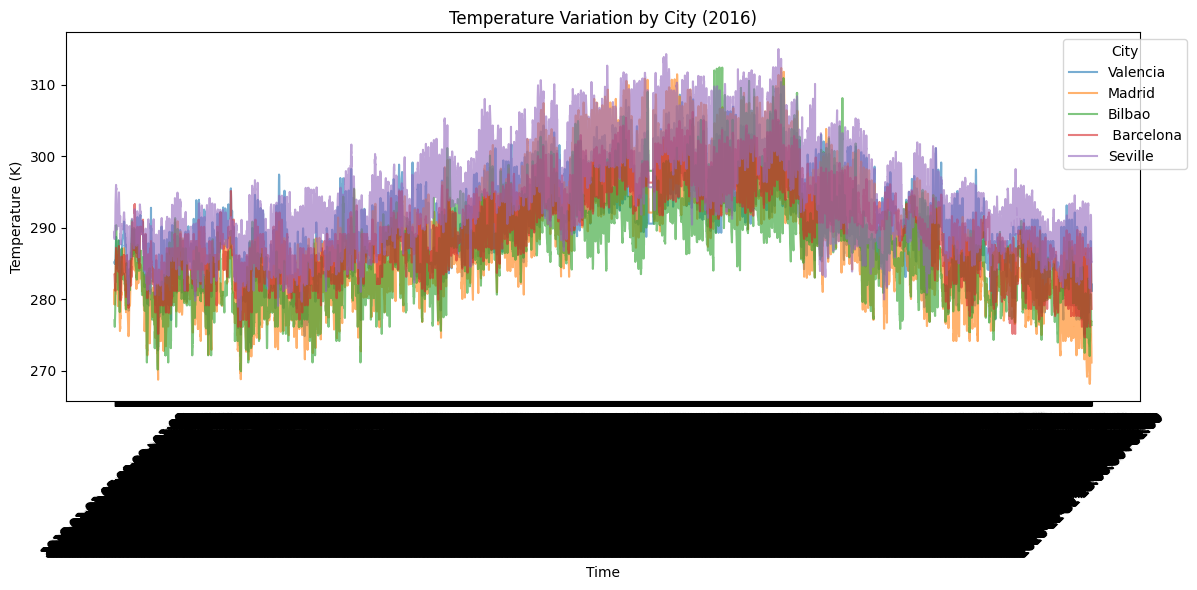

In [7]:
plt.figure(figsize=(12,6))
subset = df_cities[df_cities['time'].str.startswith('2016')].copy()
sns.lineplot(
    data=subset, x='time', y='temp', hue='city_name',
    alpha=0.6
)
plt.title('Temperature Variation by City (2016)')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.xticks(rotation=45)
plt.legend(title='City', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


# 3. Wind speed vs onshore generation per city

In [10]:
# Cap all wind_speed values at 15 m/s
df_cities['wind_speed'] = df_cities['wind_speed'].clip(upper=15)


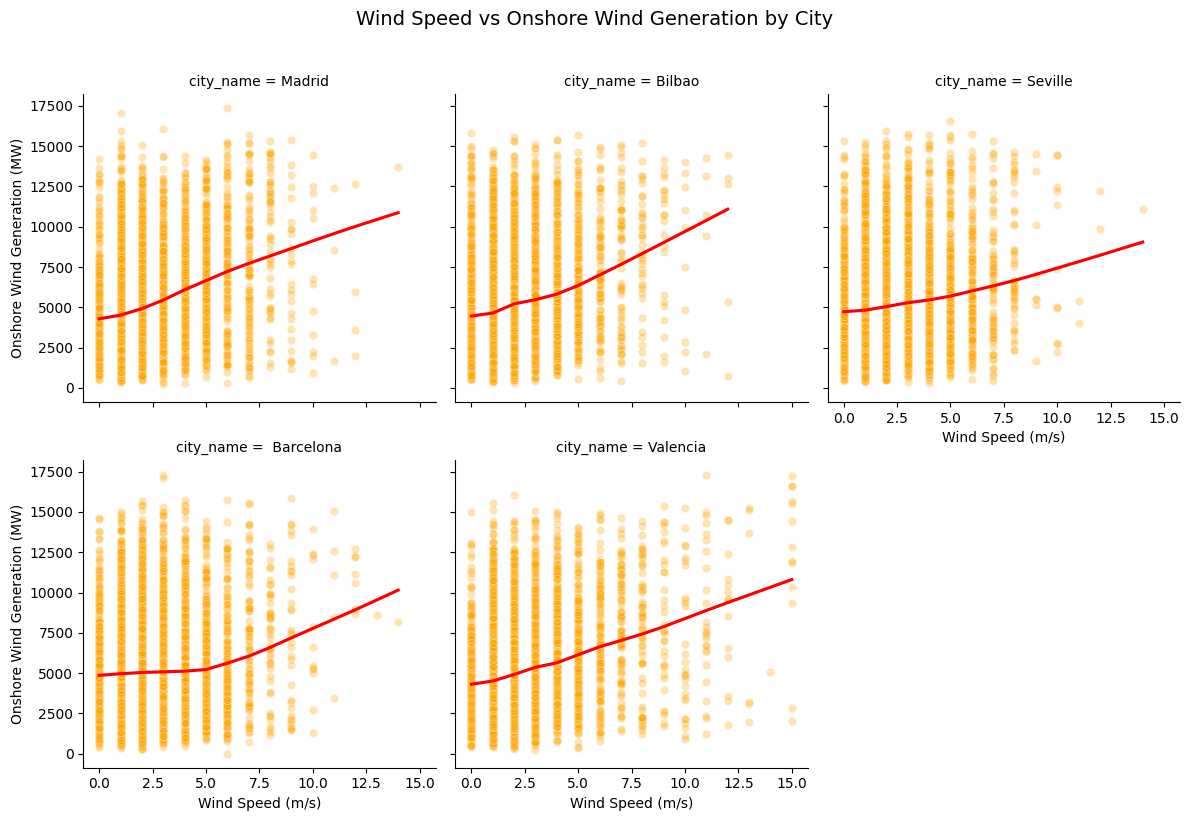

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample a subset for clarity
sample_df = df_cities.sample(20000, random_state=42)

# Create a 5-panel grid (one for each city)
g = sns.FacetGrid(
    sample_df,
    col='city_name',
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True
)

# Scatter + smooth trend
g.map_dataframe(
    sns.scatterplot,
    x='wind_speed',
    y='generation wind onshore',
    alpha=0.3,
    color='orange'
)

# Optional: add LOWESS trend line
for ax, city in zip(g.axes.flat, sample_df['city_name'].unique()):
    city_data = sample_df[sample_df['city_name'] == city]
    sns.regplot(
        x='wind_speed',
        y='generation wind onshore',
        data=city_data,
        scatter=False,
        lowess=True,
        ax=ax,
        color='red'
    )

# Titles and labels
g.set_axis_labels("Wind Speed (m/s)", "Onshore Wind Generation (MW)")
g.fig.suptitle("Wind Speed vs Onshore Wind Generation by City", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
